In [1]:
#Import libraries
from __future__ import absolute_import, division, print_function, unicode_literals
!pip3 install --upgrade tensorflow
!pip install --upgrade tensorflow-hub
!pip install scikit-learn
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pylab as plt
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score,recall_score,accuracy_score,precision_score


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
'''
Data:
The data contains chest CT images.
The data contain 3 chest cancer types 
1. Adenocarcinoma
Adenocarcinoma of the lung: Lung adenocarcinoma is the most common form of lung cancer
Adenocarcinomas are found in several common cancers, including breast, prostate and colorectal.
Adenocarcinomas of the lung are found in the outer region of the lung
in glands that secrete mucus and help us breathe.
Symptoms include coughing, hoarseness, weight loss and weakness.

2. Large cell carcinoma
Large-cell undifferentiated carcinoma: Large-cell undifferentiated carcinoma lung cancer grows and spreads quickly and can
be found anywhere in the lung. This type of lung cancer usually accounts for 10
to 15 percent of all cases of NSCLC.
Large-cell undifferentiated carcinoma tends to grow and spread quickly.

3. Squamous cell carcinoma
Squamous cell: This type of lung cancer is found centrally in the lung,
where the larger bronchi join the trachea to the lung,
or in one of the main airway branches.
Squamous cell lung cancer is responsible for about 30 percent of all non-small
cell lung cancers, and is generally linked to smoking.

4. And the last folder is the normal CT-Scan images

'''

In [2]:
train_ds='./Data/train'
test_ds='./Data/test'
val_ds='./Data/valid'

In [3]:
print('trian size adenocarcinoma',len(os.listdir(train_ds+'/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib')))
print('trian size large',len(os.listdir(train_ds+'/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa')))
print('trian size squamous',len(os.listdir(train_ds+'/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa')))
print('trian size normal',len(os.listdir(train_ds+'/normal')))
#/Chest CT-Scan images Dataset/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/"

trian size adenocarcinoma 195
trian size large 115
trian size squamous 155
trian size normal 148


In [5]:
test_adenocarcinoma=os.listdir(test_ds+'/adenocarcinoma')
test_large=os.listdir(test_ds+'/large.cell.carcinoma')
test_squamous=os.listdir(test_ds+'/squamous.cell.carcinoma')
test_normal=os.listdir(test_ds+'/normal')

print('test size adenocarcinoma ',len(test_adenocarcinoma))
print('test size large ',len(test_large))
print('test size squamous ',len(test_squamous))
print('test size ',len(test_normal))

test size adenocarcinoma  120
test size large  51
test size squamous  90
test size  54


In [6]:
#ImageDataGenerator is a class that allows pre-processing of images,
#in order to format images before using them by training and drawing a model.
#This includes resizing, orientation and color corrections.
train_datagen= ImageDataGenerator(rescale = 1./255,validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen= ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen= ImageDataGenerator(rescale = 1./255)
# Rescale 1./255 -is to transform every pixel value from range [0,255] -> [0,1]
# width_shift_range -shift the image to the left or right(horizontal shifts)
#height_shift_range -shift the image to up or down (vertically shifts).
#shear_range is Shear Intensity (Shear angle in counter-clockwise direction in degrees)
#rotation_range -randomly rotate images through any degree between 0 and 360 by providing an integer value in the rotation_range argument.

In [7]:
train_dataset  = train_datagen.flow_from_directory(directory = train_ds,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = val_ds,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = test_ds,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [8]:
#data batches
#!pip install --user numpy scipy matplotlib ipython jupyter pandas sympy nose
!pip3 install --user scipy  # install using python3
import scipy
image_batch_train, label_batch_train = next(iter(train_dataset))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_dataset.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print('0: ',dataset_labels[0])
print('1: ',dataset_labels[1])
print('2: ',dataset_labels[2])
print('3: ',dataset_labels[3])

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 4)
0:  Adenocarcinoma_Left.Lower.Lobe_T2_N0_M0_Ib
1:  Large.Cell.Carcinoma_Left.Hilum_T2_N2_M0_Iiia
2:  Normal
3:  Squamous.Cell.Carcinoma_Left.Hilum_T1_N2_M0_Iiia


In [49]:
base_model_2 = tf.keras.applications.ResNet101V2(input_shape=(224,224,3),include_top=False,weights="imagenet")
# Freezing Layers
for layer in base_model_2.layers:
   layer.trainable = False

In [ ]:
'''
A callback object can perform actions at various stages of the training (e.g. at the start or end of an epoch, before or after a single batch, etc.).​

ModelCheckpoint():

The first parameter represents the filename template.​
It can monitor either the accuracy or the loss.​
In the measure of the accuracy, higher is better (mode='max'). In the measure of loss, lower is better (mode='min').​
Setting 'save_best_only=True' ensures that the latest best model will not be overwritten.

checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
 '''

In [50]:
from tensorflow.keras import Model
from tensorflow.keras import optimizers
#The output of the CNN is also a 4D array. Where batch size would be the same as input batch size but the other 3 dimensions of the image might change depending upon the values of filter, kernel size, and padding we use.
x = base_model_2.output 
#A Flatten layer in Keras reshapes the tensor to have a shape that is equal to the number of elements contained in the tensor. This is the same thing as making a 1d-array of elements.
x = tf.keras.layers.Flatten()(x) 
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x) # Dropout 20 % of the layers
x = tf.keras.layers.Dense(train_dataset.num_classes, activation = "softmax")(x)
#The input layer is the input of the whole CNN.
model = Model(inputs= base_model_2.input , outputs = x)

checkpoint_filepath = './Data/ModelCheckpoint/'
# modelCheckpoint: a callback object that can perform actions at various stages of the training, and can monitor either the accuracy or the loss
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode="auto",min_delta=0.05,verbose=1)

callbacks_list = [early_stopping,checkpoint]

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='acc')
]
model.summary()
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=METRICS)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
          

 vation)                                                                                          
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
          

 conv4_block3_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
          

                                                                 ]                                
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
          

 conv4_block8_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block8_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block8_out (Add)         (None, 14, 14, 1024  0           ['conv4_block7_out[0][0]',       
                                )                                 'conv4_block8_3_conv[0][0]']    
                                                                                                  
 conv4_block9_preact_bn (BatchN  (None, 14, 14, 1024  4096       ['conv4_block8_out[0][0]']       
 ormalization)                  )                                                                 
                                                                                                  
 conv4_block9_preact_relu (Acti  (None, 14, 14, 1024  0          ['conv4_block9_preact_bn[0][0]'] 
 vation)  

 on)                                                                                              
                                                                                                  
 conv4_block11_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block11_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block11_2_pad[0][0]']    
                                                                                                  
 conv4_block11_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block11_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block14_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block13_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block14_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block14_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block14_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block14_1_conv[0][0]']   
 lization)

                                                                                                  
 conv4_block16_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block16_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block16_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block16_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block19_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block19_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block19_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block19_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block19_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block19_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block19_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block19_1_relu[0][0]']   
 ng2D)    

                                                                                                  
 conv4_block21_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block21_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block21_out (Add)        (None, 14, 14, 1024  0           ['conv4_block20_out[0][0]',      
                                )                                 'conv4_block21_3_conv[0][0]']   
                                                                                                  
 conv4_block22_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block21_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_blo

 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_pad (ZeroPaddin  (None, 9, 9, 512)   0           ['conv5_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359296     ['conv5_block1_2_pad[0][0]']     
                                                                                                  
 conv5_blo

 conv5_block3_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_conv[0][0]']    
                                                                                                  
 post_bn (BatchNormalization)   (None, 7, 7, 2048)   8192        ['conv5_block3_out[0][0]']       
                                                                                                  
 post_relu (Activation)         (None, 7, 7, 2048)   0           ['post_bn[0][0]']                
                                                                                                  
 flatten_2 (Flatten)            (None, 100352)       0           ['post_relu[0][0]']              
                                                                                                  
 dense_4 (Dense)                (None, 1024)         102761472   ['flatten_2[0][0]']              
          

In [51]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 1000,callbacks=callbacks_list,verbose = 1)

Epoch 1/1000
10/10 [==============================] - ETA: 0s - loss: 78.3784 - accuracy: 0.7047 - precision: 0.4089 - recall: 0.4062 - acc: 0.6110
Epoch 1: acc improved from -inf to 0.61105, saving model to ./Data/ModelCheckpoint/
10/10 [==============================] - 53s 5s/step - loss: 78.3784 - accuracy: 0.7047 - precision: 0.4089 - recall: 0.4062 - acc: 0.6110 - val_loss: 19.8770 - val_accuracy: 0.7153 - val_precision: 0.4306 - val_recall: 0.4306 - val_acc: 0.6301
Epoch 2/1000
10/10 [==============================] - ETA: 0s - loss: 13.6390 - accuracy: 0.7512 - precision: 0.5025 - recall: 0.5008 - acc: 0.6940
Epoch 2: acc improved from 0.61105 to 0.69397, saving model to ./Data/ModelCheckpoint/
10/10 [==============================] - 43s 4s/step - loss: 13.6390 - accuracy: 0.7512 - precision: 0.5025 - recall: 0.5008 - acc: 0.6940 - val_loss: 4.6065 - val_accuracy: 0.7639 - val_precision: 0.5278 - val_recall: 0.5278 - val_acc: 0.7648
Epoch 3/1000
10/10 [========================

In [52]:
#save model
model.save('./Data/Model')

INFO:tensorflow:Assets written to: ./Data/Model/assets


In [53]:
y_pred=[]
model = keras.models.load_model('./Data/Model')
'''This function loads an image'''
def prepare_img(img, img_width, img_height,channels):
    img =  tf.keras.preprocessing.image.img_to_array(img)
    img = img.reshape(1, img_width, img_height, channels).astype('float32')
    img = img / 255.0
    return img

for img in test_adenocarcinoma:
    img = load_img('./Data/test/adenocarcinoma/' + img ,target_size=(224, 224))
    img = prepare_img(img,224,224,3)
    predictions = model.predict(img)
    index_of_higher_value  = predictions[0].argmax()
    y_pred.append(predictions[0].argmax())

for img in test_large:
    img = load_img('./Data/test/large.cell.carcinoma/' + img ,target_size=(224, 224))
    img = prepare_img(img,224,224,3)
    predictions = model.predict(img)
    index_of_higher_value  = predictions[0].argmax()
    y_pred.append(predictions[0].argmax())


for img in test_normal:
    img = load_img('./Data/test/normal/' + img ,target_size=(224, 224))
    img = prepare_img(img,224,224,3)
    predictions = model.predict(img)
    index_of_higher_value = predictions[0].argmax()
    y_pred.append(predictions[0].argmax())
    
for img in test_squamous:
    img = load_img('./Data/test/squamous.cell.carcinoma/' + img ,target_size=(224, 224))
    img = prepare_img(img,224,224,3)
    predictions = model.predict(img)
    index_of_higher_value = predictions[0].argmax()
    y_pred.append(predictions[0].argmax())


                           


In [59]:

y_test=[0]*len(test_adenocarcinoma)
y_test+=[1]*len(test_large)
y_test+=[2]*len(test_normal)
y_test+=[3]*len(test_squamous)
print('Accuracy: ',round(accuracy_score(y_test, y_pred),2))
print('Recall: ',round(recall_score(y_test, y_pred,average='weighted'),2))
print('Precision: ',round(precision_score(y_test, y_pred,average='weighted'),2))
print('f1 score :',round(f1_score(y_test,y_pred, average='weighted'),2))

print(classification_report(y_test, y_pred))

Accuracy:  0.71
Recall:  0.71
Precision:  0.72
f1 score : 0.71
              precision    recall  f1-score   support

           0       0.66      0.87      0.75       120
           1       0.50      0.43      0.46        51
           2       1.00      0.94      0.97        54
           3       0.76      0.53      0.63        90

    accuracy                           0.71       315
   macro avg       0.73      0.69      0.70       315
weighted avg       0.72      0.71      0.71       315



adenocarcinoma


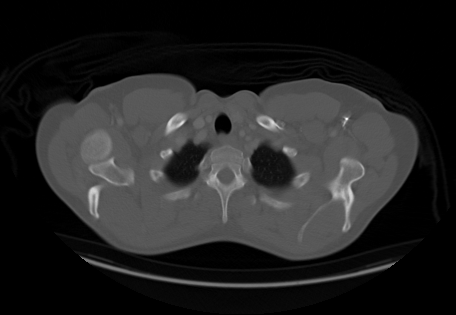

large


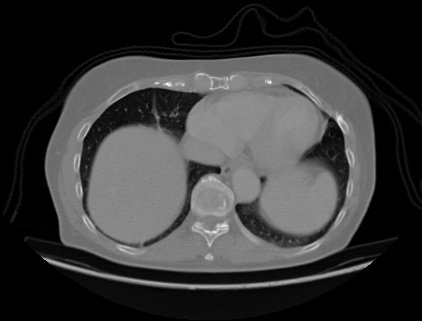

squamous


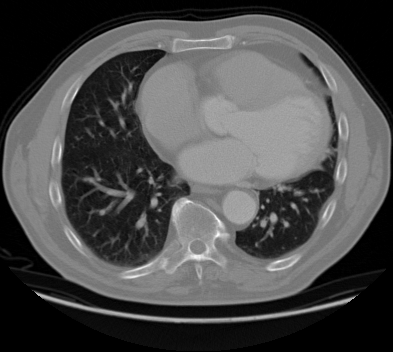

normal


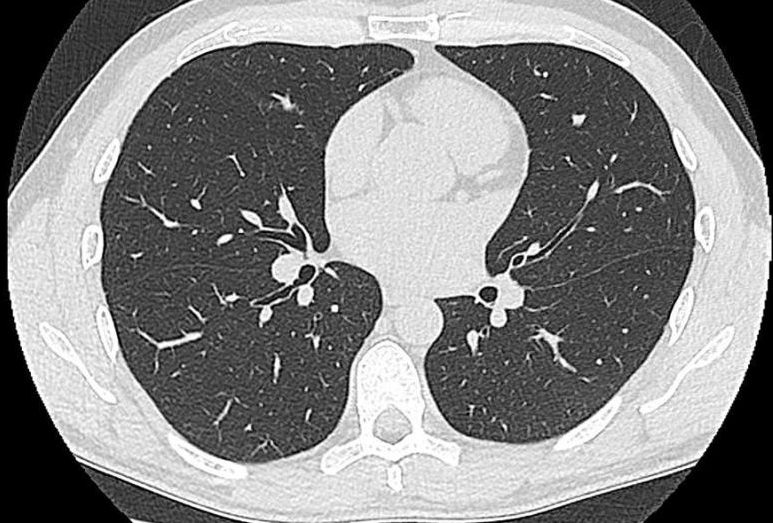

In [69]:
from IPython.display import Image 


image_adenocarcinoma = Image('./Data/test/adenocarcinoma/'+test_adenocarcinoma[0])

image_large = Image('./Data/test/large.cell.carcinoma/'+test_large[0])

image_squamous = Image('./Data/test/squamous.cell.carcinoma/'+test_squamous[0])

image_normal = Image('./Data/test/normal/'+test_normal[1])
print('adenocarcinoma')
display(image_adenocarcinoma)
print('large')
display(image_large)
print('squamous')
display(image_squamous)
print('normal')
display(image_normal)

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'acc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_acc'])


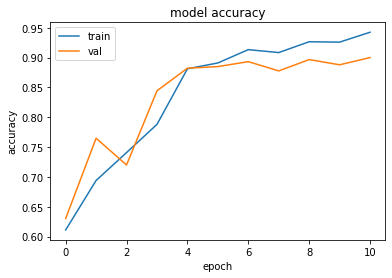

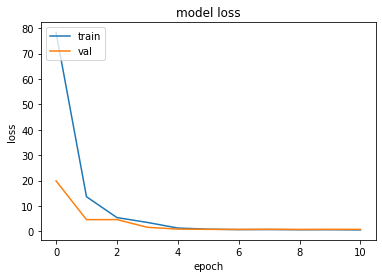

In [61]:
# list all data in history
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()